In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


# GANs

En este primer ejemplo utilizaremos dos redes fully connected muy básicas para ilustrar el funcionamiento de las GANs. Realizaremos el entrenamiento utilizando el dataset MNIST, por lo que al finalizar el proceso, podremos usar la red Generadora para producir imágenes nuevas, similares a dígitos manuscritos.

## Dataset
Comenzaremos descargando el dataset y visualizando algunas imágenes de muestra. Usaremos la clase `MNIST` de `torchvision.datasets` que nos descargará el dataset a nuestro entorno en la ruta indicada y realizará las transformaciones necesarias para convertir las imágenes en tensores y normalizar los valores de los píxeles en el rango [-1, 1].

In [3]:
transforms = transforms.Compose(
    [
        transforms.ToTensor(), # Transforma las imágenes a tensores
        transforms.Normalize((0.5,), (0.5,)), # Normaliza los valores de los píxeles
    ]
)

Ahora descargaremos el dataset a nuestro entorno. Si el dataset ya existe, no se vuelve a descargar.

In [4]:
dataset = datasets.MNIST(root="./", transform=transforms, download=True)

In [5]:
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

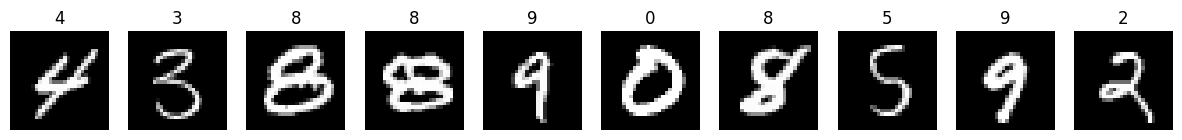

In [6]:
for img, lbl in dataloader:
    fig, ax = plt.subplots(1, 10, figsize=(15,6))
    for i in range(10):
        ax[i].imshow(img[i][0], cmap='gray')
        ax[i].axis(False)
        ax[i].set_title(lbl[i].item())
    break

## Discriminador

Crearemos la red discriminadora, cuyo objetivo será determinar si la imágen de entrada es real o si fue generada artificialmente por la red generadora. Usaremos dos capas lineales con una sola unidad de salida, cuya activación será la función sigmoide para producir un valor entre 0 y 1. Usaremos como convención que 1 corresponde a imágenes reales y 0 a imágenes falsas.

In [7]:
class Discriminator(nn.Module):
    def __init__(self, in_features=28*28): # La red espera recibir una imágen de MNIST "aplanada" en forma de vector
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)

Instanciamos un discriminador y vemos si hay errores procesando datos aleatorios

In [8]:
D = Discriminator()

In [9]:
x = torch.randn(5, 28*28)
y_hat = D(x)
y_hat

tensor([[0.4936],
        [0.5246],
        [0.4895],
        [0.5220],
        [0.5272]], grad_fn=<SigmoidBackward0>)

Vemos que para los 5 ejemplos de entrada, se produce un único valor de salida entre 0 y 1.

## Generador
En este caso también usaremos una red fully connected que deberá producir una salida de las mismas dimensiones que las imágenes de MNIST a partir de un vector muestreado aleatoriamente del espacio latente.

La última capa del generador tendrá una activación tanh que llevará los valores de salida al rango (-1, 1), al igual que las imágenes de entrada del discriminador.

In [10]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim=28*28):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Tanh(),  
        )

    def forward(self, x):
        return self.gen(x)

En este caso el ensayo consistirá en instanciar un generador y usar vectores aleatorios de dimensión Z_DIM para producir imágenes.

In [11]:
G = Generator(z_dim=32)

In [12]:
z = torch.randn(5, 32)
fake_images = G(z)
fake_images.shape

torch.Size([5, 784])

Vemos que generó un vector de tamaño 784 para cada vector de entrada (de tamaño 32).

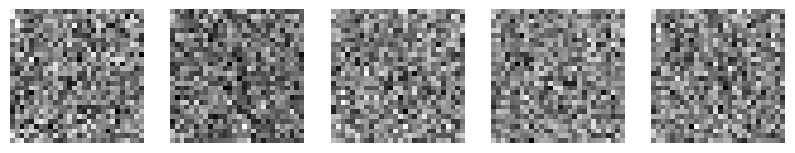

In [13]:
# Hacemos reshape y ploteamos
fake_images = fake_images.reshape(-1, 28, 28)
fig, ax = plt.subplots(1, 5, figsize=(10,6))
for i in range(5):
    ax[i].imshow(fake_images[i].detach().numpy(), cmap='gray')
    ax[i].axis(False)

Vemos que son imágenes de puro ruido, lo cual tiene sentido ya que la red no está entrenada todavía.

## Entrenamiento

Implementaremos el loop de entrenamiento, tal cual está propuesto en el paper:
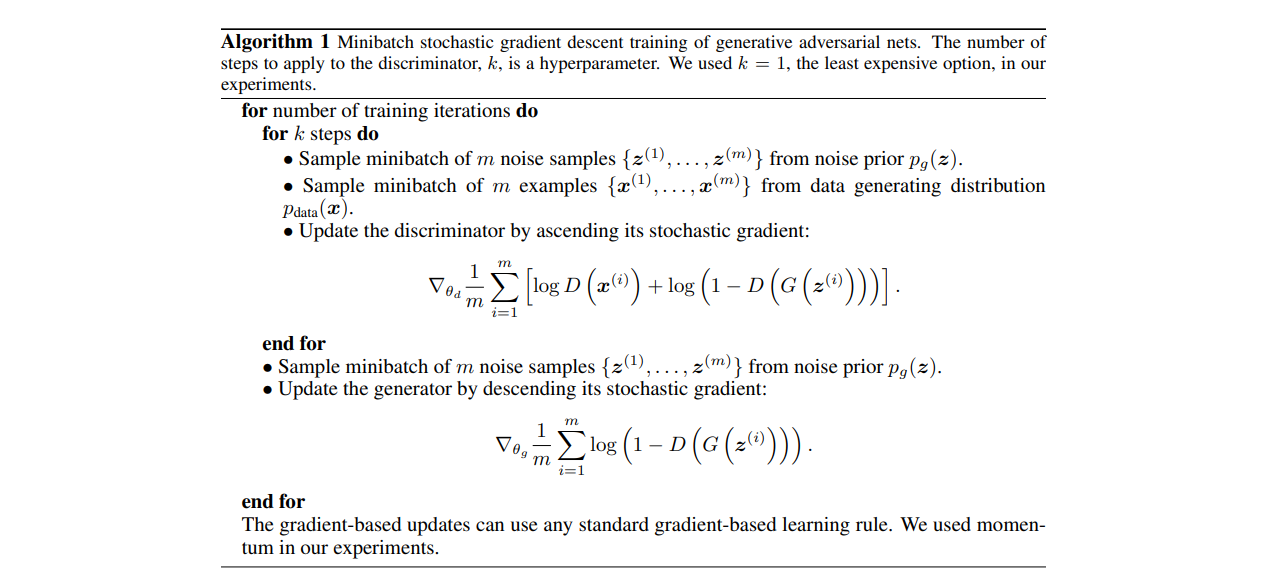

Ahora queda definir algunos hiperparámetros, instanciar los optimizadores y comenzar el entrenamiento

In [14]:
# Hyperparameters etc.
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 3e-4
Z_DIM = 64
NUM_EPOCHS = 100

In [15]:
D = Discriminator()
G = Generator(z_dim=Z_DIM)

In [16]:
opt_D = optim.Adam(D.parameters(), lr=LEARNING_RATE)
opt_G = optim.Adam(G.parameters(), lr=LEARNING_RATE)
loss_fn = nn.BCELoss().to(DEVICE)

In [17]:
# Usaremos la implementación de Pytorch de la BCE Loss para calcular las funciones de pérdida necesarias para entrenar ambas redes

def train(D, G, z_dim, loss_fn, opt_D, opt_G, dataloader, num_epochs, device, show_every_n_epochs=10):

    G = G.to(device)
    D = D.to(device)
    loss_fn = loss_fn.to(device)
    N_samples = 10
    fixed_sample = torch.randn(N_samples, z_dim).to(device)
    
    losses_D = []
    losses_G = []
    
    
    # Comenzamos el loop de entrenamiento
    for epoch in range(NUM_EPOCHS):
        progress = tqdm(dataloader)
        progress.set_description(desc=f"Epoch {epoch+1}")
    
        batch_loss_D = []
        batch_loss_G = []
        
        for real_img, _ in progress: # Tomamos una muestra del dataloader, descartando las etiquetas que no son necesarias
    
            ### DISCRIMINADOR ###
            
            real_img = real_img.view(-1, 784).to(device) # Aplanamos las imágenes
            
            # Debemos estar seguros del tamaño del batch, ya que el tamaño del dataset puede no ser divisible por BATCH_SIZE
            batch_size = real_img.shape[0]
    
            # Tomamos una muestra de m vectores de dimensión z_dim, donde m es el tamaño (real) del batch
            z = torch.randn(batch_size, z_dim).to(device)
    
            # Generamos imágenes falsas usando los vectores muestreados
            fake_img = G(z)
    
            # Calculamos la salida del discriminador para las imágenes reales
            disc_real = D(real_img) # Deben ser valores cercanos a 1
    
            # Calculamos la salida del discriminador para las imágenes falsas
            disc_fake = D(fake_img) # Deben ser valores cercanos a 0
    
            # Calculamos el primer término de la función de pérdida del discriminador, que corresponde a las imágenes reales
            lossD_real = loss_fn(disc_real, torch.ones_like(disc_real)) 
            # Calculamos el primer término de la función de pérdida del discriminador, que corresponde a las imágenes falsas
            lossD_fake = loss_fn(disc_fake, torch.zeros_like(disc_fake))
            # Componemos la pérdida del discriminador
            lossD = lossD_real + lossD_fake
            # Reseteamos y calculamos gradientes y actualizamos los parámetros de la red
            D.zero_grad()
            lossD.backward()
            opt_D.step()
    
            ### GENERADOR ###
            # Tomamos una muestra de m vectores de dimensión z_dim, donde m es el tamaño (real) del batch
            z = torch.randn(batch_size, z_dim).to(device)
            
            # Generamos imágenes falsas a partir de la muestra
            fake_img = G(z)
            # Las procesamos con el discriminador
            disc_fake = D(fake_img)
            # Como estamos entrenando el generador, el objetivo es lograr que el discriminador crea que son reales (output=1)
            lossG = loss_fn(disc_fake, torch.ones_like(disc_fake))
            # Reseteamos y calculamos gradientes y actualizamos los parámetros de la red
            G.zero_grad()
            lossG.backward()
            opt_G.step()
    
            progress.set_postfix({'lossD': lossD.item(), 'lossG': lossG.item()})
    
            batch_loss_D.append(lossD.item())
            batch_loss_G.append(lossG.item())
    
        batch_loss_D = sum(batch_loss_D) / len(batch_loss_D)
        batch_loss_G = sum(batch_loss_G) / len(batch_loss_G)
        progress.set_postfix({'lossD': batch_loss_D, 'lossG': batch_loss_G})

        losses_D.append(batch_loss_D)
        losses_G.append(batch_loss_G)
    
        if show_every_n_epochs and (epoch % show_every_n_epochs == 0):
            with torch.no_grad():
                generated_images = G(fixed_sample).reshape(-1, 28, 28).to('cpu')
            fig, ax = plt.subplots(1, N_samples, figsize=(15,6))
            for i in range(N_samples):
                ax[i].imshow(generated_images[i].detach().numpy(), cmap='gray')
                ax[i].axis(False)
            plt.show()
    return losses_D, losses_G

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 12.40it/s, lossD=0.47, lossG=1.68]


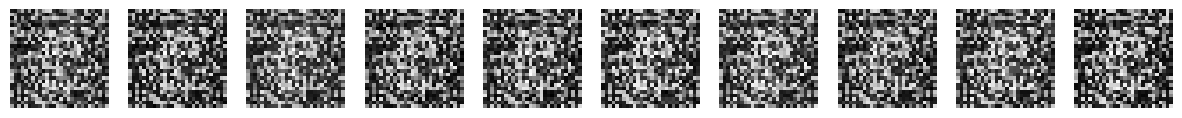

Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.36it/s, lossD=0.577, lossG=1.69]


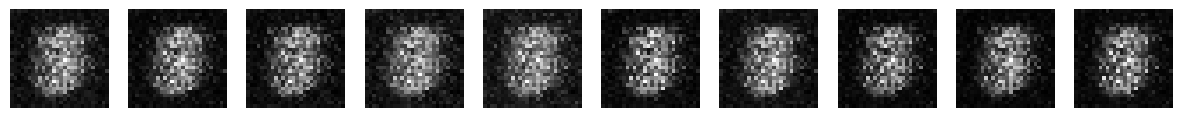

Epoch 21: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.23it/s, lossD=1.82, lossG=0.714]


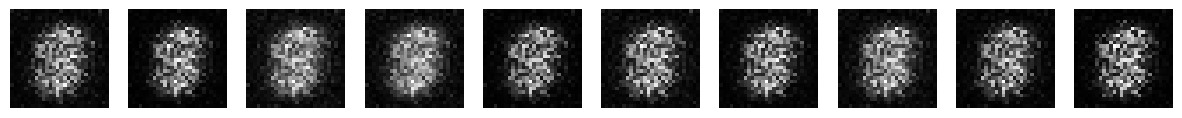

Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.26it/s, lossD=1.25, lossG=1.02]


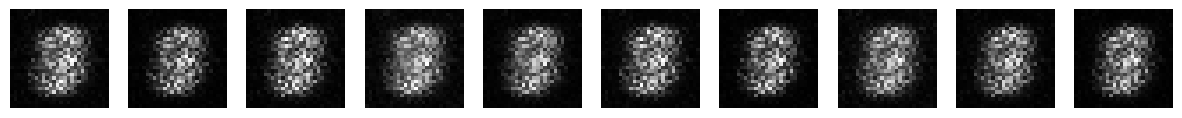

Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.42it/s, lossD=1.22, lossG=1.01]


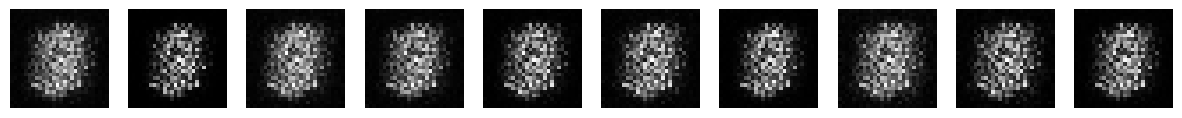

Epoch 51: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.18it/s, lossD=0.294, lossG=2.76]


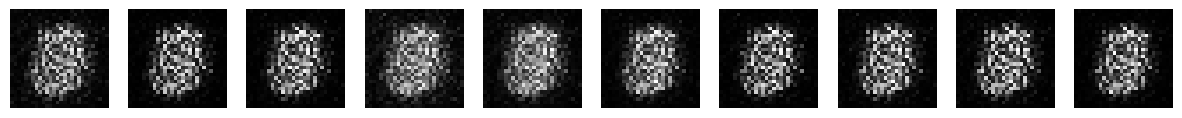

Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.13it/s, lossD=1.15, lossG=1.18]


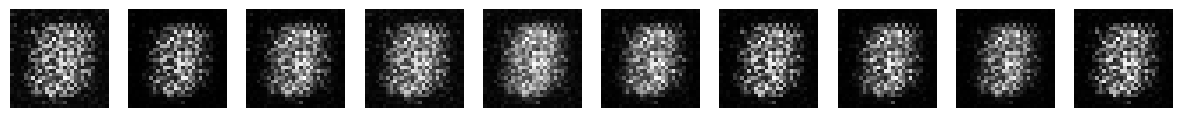

Epoch 71: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.25it/s, lossD=0.401, lossG=1.77]


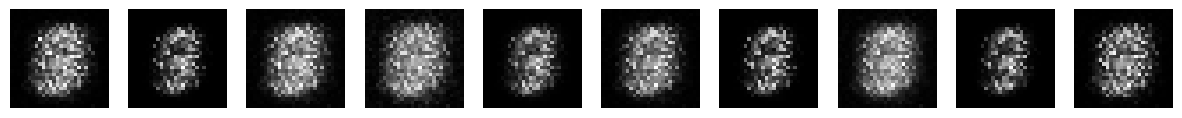

Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.17it/s, lossD=1.12, lossG=1.21]


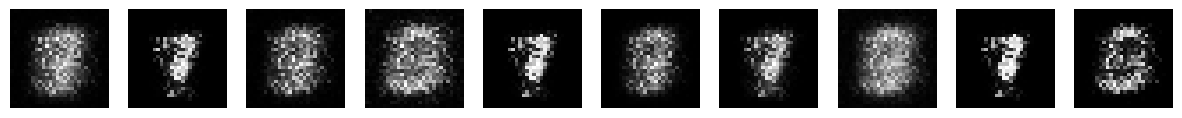

Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.23it/s, lossD=1.08, lossG=1.29]


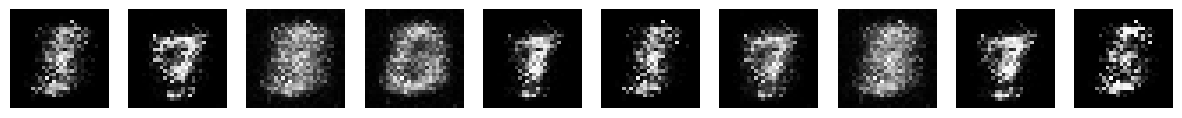

Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 12.96it/s, lossD=1.16, lossG=1.12]


In [18]:
losses_D, losses_G = train(D, G, Z_DIM, loss_fn, opt_D, opt_G, dataloader, num_epochs=100, device=DEVICE)

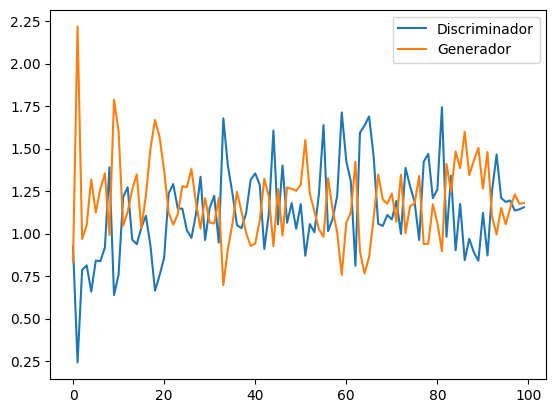

In [19]:
plt.plot(losses_D)
plt.plot(losses_G)
plt.legend(['Discriminador', 'Generador'])

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.29it/s, lossD=1.05, lossG=1.38]


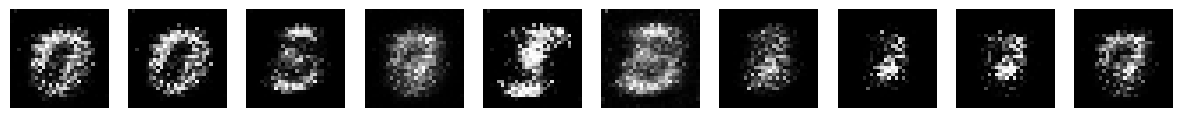

Epoch 11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.80it/s, lossD=1.35, lossG=1.1]


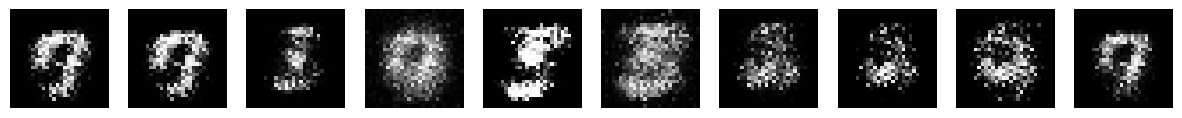

Epoch 21: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.67it/s, lossD=1.41, lossG=0.961]


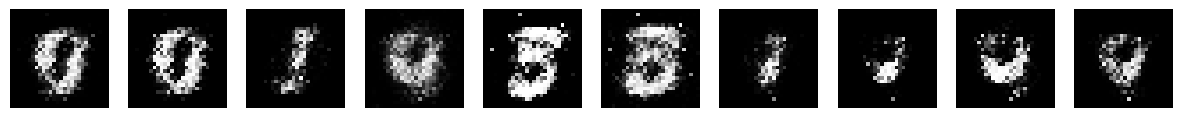

Epoch 31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.65it/s, lossD=1.31, lossG=1.4]


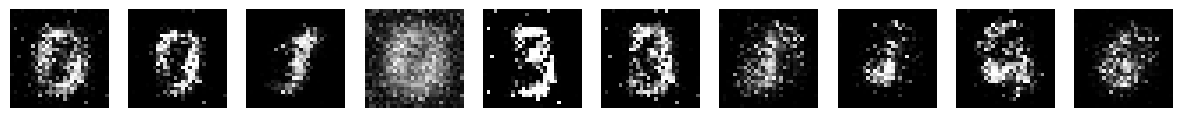

Epoch 41: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.85it/s, lossD=0.8, lossG=1.74]


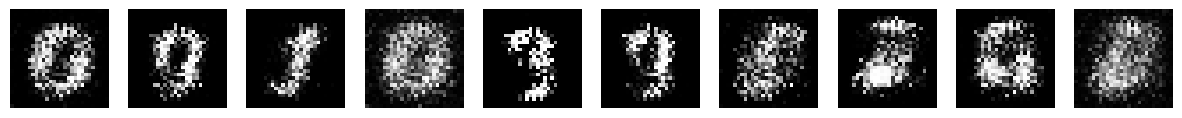

Epoch 51: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.65it/s, lossD=1.05, lossG=1.6]


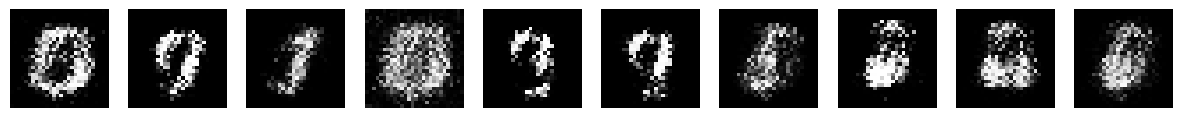

Epoch 61: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.77it/s, lossD=0.654, lossG=1.85]


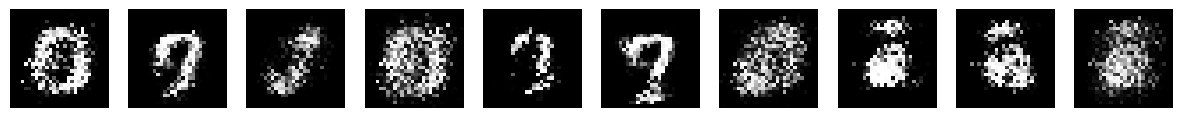

Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.66it/s, lossD=1.26, lossG=1.22]


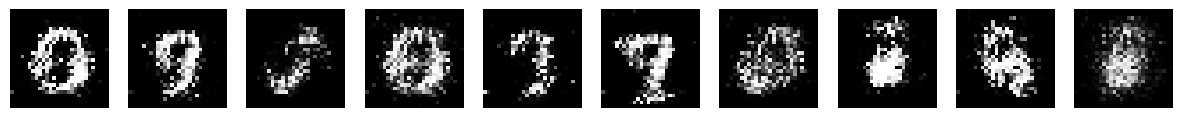

Epoch 81: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.63it/s, lossD=0.757, lossG=1.61]


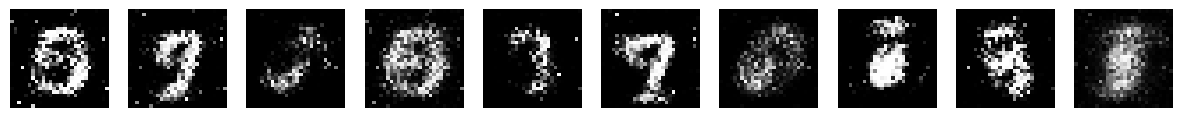

Epoch 91: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.53it/s, lossD=1, lossG=1.45]


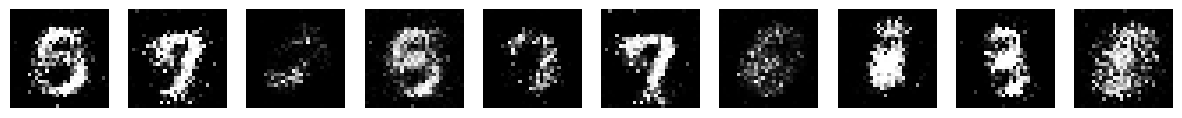

Epoch 100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.74it/s, lossD=0.991, lossG=1.29]


In [20]:
losses_D, losses_G = train(D, G, Z_DIM, loss_fn, opt_D, opt_G, dataloader, num_epochs=100, device=DEVICE)

Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.42it/s, lossD=0.935, lossG=1.58]


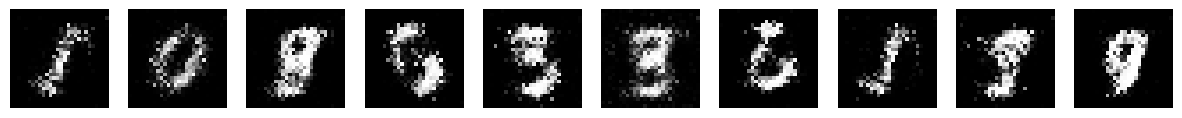

Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.49it/s, lossD=1.75, lossG=1.19]


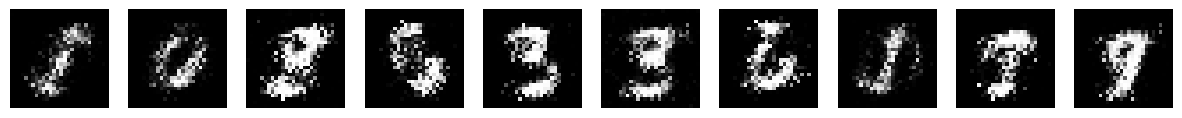

Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:09<00:00, 13.03it/s, lossD=1.33, lossG=1.35]


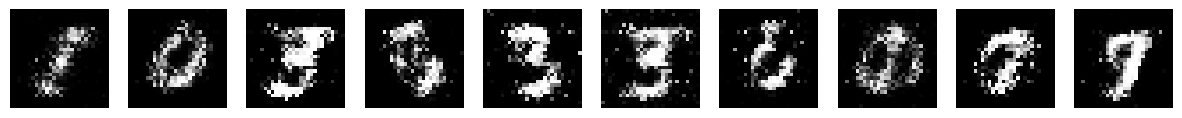

Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.45it/s, lossD=1.23, lossG=1.24]


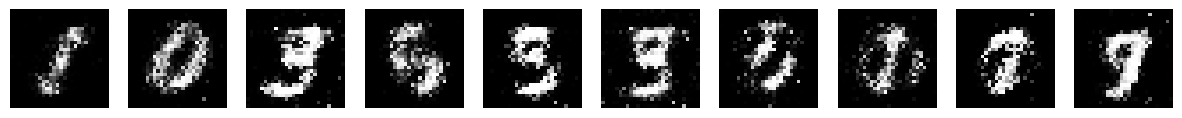

Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.31it/s, lossD=1.41, lossG=1.38]


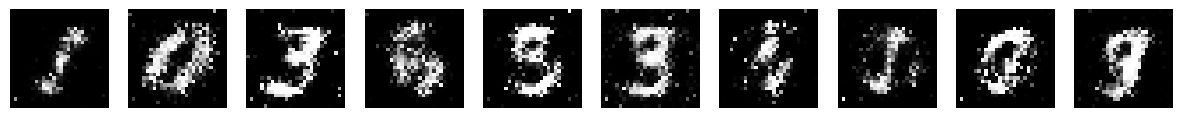

Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.34it/s, lossD=1.26, lossG=1.44]


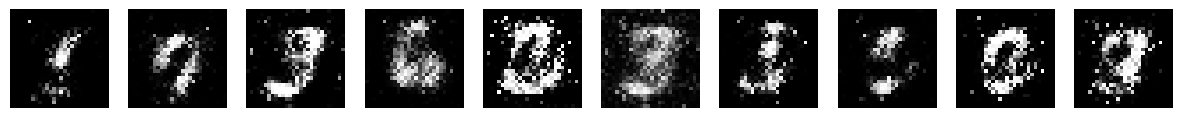

Epoch 61: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.64it/s, lossD=1.64, lossG=0.983]


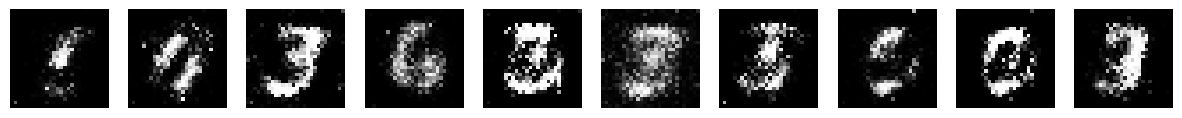

Epoch 71: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.29it/s, lossD=1.15, lossG=1.3]


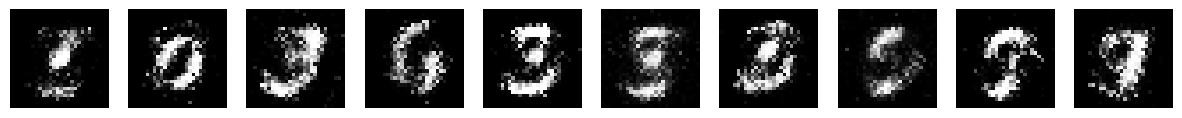

Epoch 81: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.48it/s, lossD=1.67, lossG=0.967]


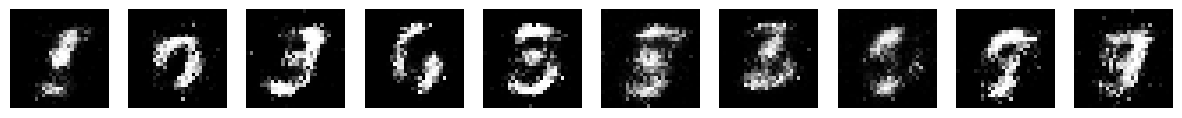

Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.43it/s, lossD=1.15, lossG=1.36]


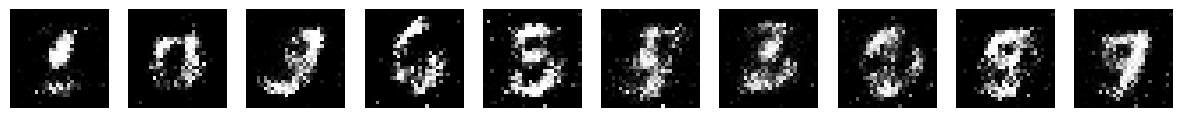

Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.13it/s, lossD=1.01, lossG=1.52]


In [21]:
losses_D, losses_G = train(D, G, Z_DIM, loss_fn, opt_D, opt_G, dataloader, num_epochs=100, device=DEVICE)

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.15it/s, lossD=1.06, lossG=1.82]


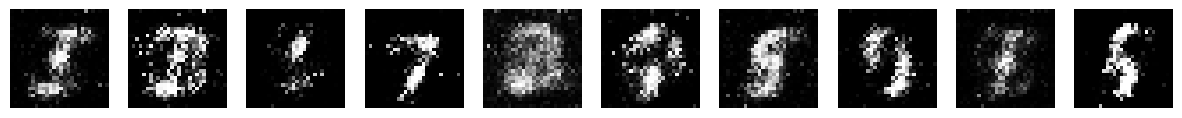

Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.47it/s, lossD=1.09, lossG=1.57]


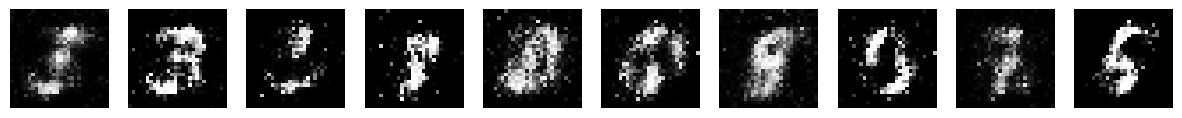

Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.56it/s, lossD=1.01, lossG=1.56]


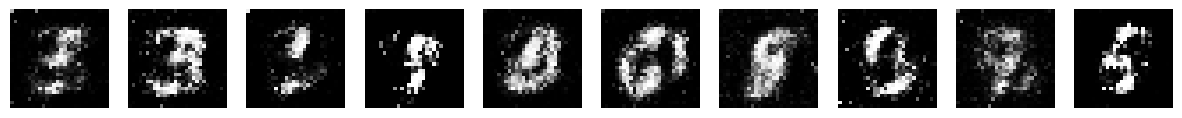

Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.52it/s, lossD=1.25, lossG=1.28]


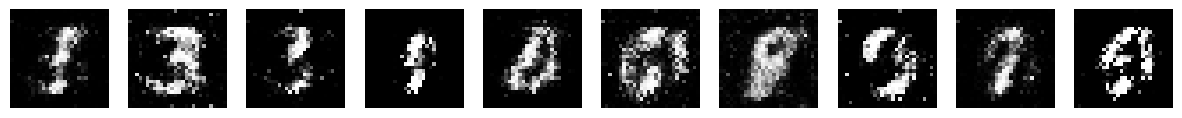

Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.49it/s, lossD=1.15, lossG=1.52]


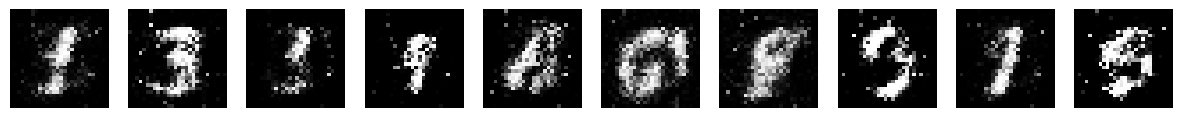

Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.29it/s, lossD=1.51, lossG=1.07]


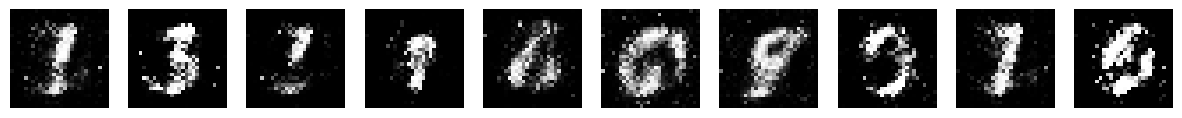

Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.24it/s, lossD=1.14, lossG=1.16]


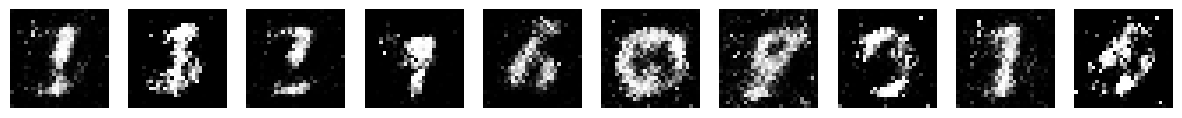

Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.30it/s, lossD=1.26, lossG=1.29]


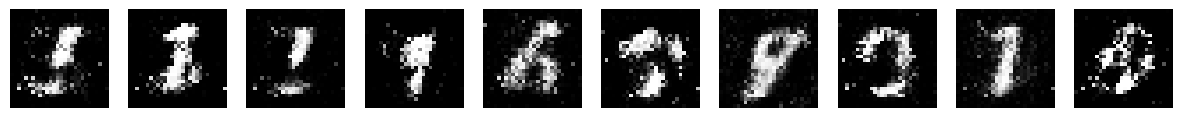

Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.50it/s, lossD=1.03, lossG=1.47]


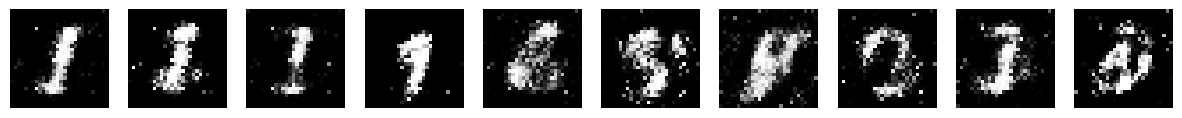

Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.36it/s, lossD=1.03, lossG=1.54]


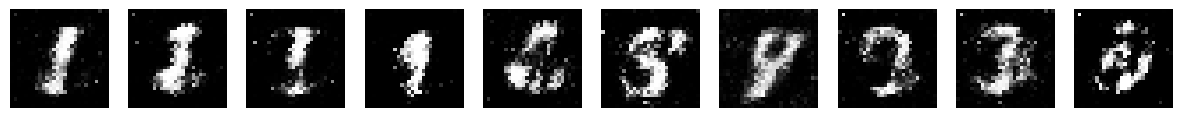

Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:08<00:00, 13.34it/s, lossD=1.12, lossG=1.56]


In [22]:
losses_D, losses_G = train(D, G, Z_DIM, loss_fn, opt_D, opt_G, dataloader, num_epochs=100, device=DEVICE)